In [11]:
'''GAN'''

#Import necessery packages

matplotlib_is_available = True

try:
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.autograd import Variable
    from matplotlib import pyplot as plt
except ImportError:
    print("Packages could not be imported")
    matplotlib_is_available = False



In [2]:
#Set the function parameters and other data
data_mean = 4
data_stddev = 1.25

#Set the initial data for the CNN-network data in terms of dimensions to use in input, one layer and output.

g_input_size = 1      # Random noise dimension coming into generator, per output vector
g_hidden_size = 5     # Generator complexity
g_output_size = 1     # Size of generated output vector
d_input_size = 500    # Minibatch size - cardinality of distributions
d_hidden_size = 10    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification

minibatch_size = d_input_size

In [3]:
#Define preprocess function 

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean #Calculate difference between each value and the mean of the values
    var = torch.mean(torch.pow(diffs, 2.0)) #torch.pow(diffs, 2.0) is same as diff**2 for every element
    std = torch.pow(var, 0.5) 
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

### Select preprocess to be get_moments(d) and discriminator input function to be x=4

(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))


Using data [Only 4 moments]




\begin{align}
\text{standard deviation} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \overline{x})^2} \newline
\text{var} = \frac{1}{N} \sum_{i=1}^N (\text{diffs})^2 \newline
\text{std = stamdard deviation} = \sqrt{\frac{1}{N} \sum_{i=1}^N (\text{diffs})^2} \newline
\text{zscores} = \frac{\text{diffs}}{\text{std}} \newline
\text{skews} = \frac{\sum_{i=1}^N \text{zscores}_i^3}{N} \newline
kurtoses = mean(zscores^4)-3 \newline
\text{final} = (mean value, standard deviation, skews, kurtoses)
\end{align}
 
 zscores is how much each datapoint differs from the standard deviation.
 
 Skewness is a measure of the symmetry in a distribution. 
 
 Kurtosis is a measure of the combined sizes of the two tails. It measures the amount of probability in the tails. 
 
 Theese numbers are saved in an list "final".

In [4]:
#Define activationfunctions
discriminator_activation_function = torch.sigmoid  #Standard sigmoid activation function
generator_activation_function = torch.tanh    #Returns a new tensor with the hyperbolic tangent of the elements of input

#Function to extract values from generated fake data in a list
def extract(v):
    return v.data.storage().tolist()

#Function to return the mean and standard deviation as numpy arrays
def stats(d):
    return [np.mean(d), np.std(d)]



In [5]:
# ##### DATA: Target data and generator input data

def get_distribution_sampler(mean, standard):
    return lambda n: torch.Tensor(np.random.normal(mean, standard, (1, n)))  # Random numbers with stated mean and standard deviation

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Random numbers between 0 and 1 in a m x n matrix.


The distributed data can have; Mean: 3.911 and standard deviation is: 1.301 
 The skewness is: -0.192 and kurtotis is: -0.124 


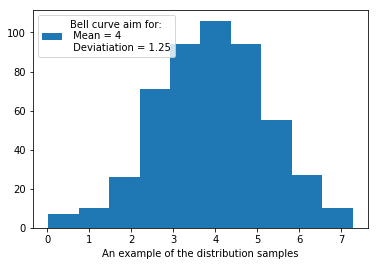

In [6]:
#Show how the distributed data looks like
dist_func = get_distribution_sampler(data_mean, data_stddev) #Get the distributed values, amount: 

dist_real_data = dist_func(d_input_size)

mean, standard, skew, kurt = extract(preprocess(dist_real_data))

print("The distributed data can have; Mean: {:.3f} and standard deviation is: {:.3f} \n The skewness is: {:.3f} and kurtotis is: {:.3f} ".format(mean, standard, skew, kurt))
plt.hist(dist_real_data)
plt.xlabel("An example of the distribution samples")
plt.legend(['Bell curve aim for: \n Mean = 4 \n Deviatiation = 1.25'], loc='best')
plt.show()

In [7]:
'''Construct class Generator'''

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):  #Input generator input size, generator complexity 
        super(Generator, self).__init__()                     #Output size and torch.tanh function (1 dimension in input and output)
        self.map1 = nn.Linear(input_size, hidden_size) #The sizes are the weigths and biases
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f
        '''Applies a linear transformation to the incoming data: y = xA^T + b
        Parameters:	
        in_features – size of each input sample
        out_features – size of each output sample'''
    def forward(self, x):   #Calculating size of inpput, hidden and output - layers. Using forward propegation
        x = self.map1(x)        #convolutional
        x = self.f(x)           #Activation
        x = self.map2(x)        #Convolutional
        x = self.f(x)           #Activation
        x = self.map3(x)        #Convolutional
        return x
    
        #Explination of input/output from nn.Linear method
        '''Input: (N, *, in_features) where * means any number of additional dimensions
            Output: (N, *, out_features) where all but the last dimension are the same shape as the input.'''
        
        '''Futher explination about the torch.nn.Linear'''
        '''https://pytorch.org/docs/stable/nn.html#linear'''

In [8]:
'''Construct class Discriminator'''
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))     #Convolutional + activation
        x = self.f(self.map2(x))     #Convolutional + activation
        return self.f(self.map3(x))  #Convolutional + activation   ===> Same as Generator but more compact

Without any training system believe the mean is:0.123 and standard deviation is: 0.025 
 The skewness is: -0.097 and kurtotis is: -1.291 


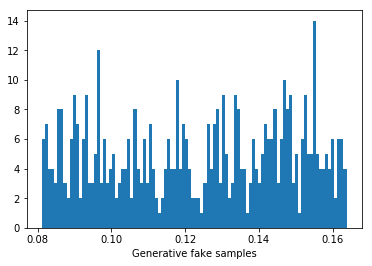

In [20]:
#Show how generated data can look like without any training
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)

gen_input = Variable(gi_sampler(minibatch_size, g_input_size))

g_fake_data = G(gen_input)

mean, standard, skew, kurt = extract(preprocess(g_fake_data))

print("Without any training system believe the mean is:{:.3f} and standard deviation is: {:.3f} \n The skewness is: {:.3f} and kurtotis is: {:.3f} ".format(mean, standard, skew, kurt))

plt.hist(extract(g_fake_data), bins=100)
plt.xlabel("Generative fake samples")
plt.show()

In [21]:
## The training function

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions - 500
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3     #The step size calculated by gradient descent
    g_learning_rate = 1e-3
    sgd_momentum = 0.9         #Parameter that changes how frequent a matched curve should have, increase the width

    num_epochs = 2000   #Number of learning loops, 5000 is standard, 2000 is enough to learn okey
    print_interval = 100
    d_steps = 20     #Number of runs to just optimize the discriminator
    g_steps = 20     # -- ll --- generator
    
    dfe, dre, ge = 0, 0, 0   #dfe = Distributed fake error   dre = Distributed real error    ge = generated error
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid   #activationfunctions 
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)  #Get real distribution
    gi_sampler = get_generator_input_sampler()                    #Get random noise
    
    G = Generator(input_size=g_input_size,                        #Generator design with three linear layers
                  hidden_size=g_hidden_size,                     
                  output_size=g_output_size,
                  f=generator_activation_function)
    
    D = Discriminator(input_size=d_input_func(d_input_size),     #Discriminator design same as genertors
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    
    #Define cost function
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    #Takes two input arguments, the first is the networks decision and the other one the true answear. The function calculates 
    #the loss between the two values.
    
    #Define distributer and generator optimizers
    #Implements stochastic gradient descent (optionally with momentum, but it is recomended with momentum = 0.9)
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)
    
    
    

    for epoch in range(num_epochs):   #Loop over all epochs
        for d_index in range(d_steps):    #Only optimize the discriminator for desired number of loops
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size)) #create some random correct data
            d_real_decision = D(preprocess(d_real_data))    #Discriminator decides if real data is real
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true, cost function gives the error
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)) #Create fake data (noise)
            d_fake_data = G(d_gen_input).detach()  #Generates fake data, detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t())) #Discriminator decides if fake data is real
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  #Save decision and true answear, zeros = fake
            d_fake_error.backward()  #Stores gradient to tell direction for the best improvements
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0] #Assign in order to print errors later

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size)) #Create som random noise for the generator
            g_fake_data = G(gen_input) #Generate fake data of the input noise
            dg_fake_decision = D(preprocess(g_fake_data.t()))  #Descriminator decides wether generated data is real or fake
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Calculate the cost between the true answear = 1
            #and the fake answear = dg_fake_decision with nn.BCEloss(dg_fake_decision, 1)

            g_error.backward()   #Save the gradient for best improvement for G on D's response
            g_optimizer.step()  # Optimizes G depending on the gradient calculated in .backward(). 
                                 #Changes values in size of g_learning_rate
            ge = extract(g_error)[0]  #Save generated error in order to calculate it

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


Epoch 0: D (0.9188041090965271 real_err, 0.5077190399169922 fake_err) G (0.9174132347106934 err); Real Dist ([4.016131082773208, 1.2693787264912735]),  Fake Dist ([0.07929776197671891, 0.04581590853912122]) 
Epoch 20: D (0.6812214851379395 real_err, 0.6743196249008179 fake_err) G (0.7122272849082947 err); Real Dist ([3.846702688217163, 1.2979507305379185]),  Fake Dist ([0.11985904467105865, 0.04680153267139585]) 
Epoch 40: D (0.6457257270812988 real_err, 0.6493307948112488 fake_err) G (0.7388244271278381 err); Real Dist ([3.9944289039596916, 1.2657324831649026]),  Fake Dist ([0.28775036734342574, 0.04885718903291781]) 
Epoch 60: D (0.5923328995704651 real_err, 0.6083709001541138 fake_err) G (0.773888111114502 err); Real Dist ([3.916284317925572, 1.258076732795935]),  Fake Dist ([0.8868897527456283, 0.03606688050936401]) 
Epoch 80: D (0.6000878810882568 real_err, 0.6186971664428711 fake_err) G (0.7730740308761597 err); Real Dist ([3.9384392979294063, 1.2189075485892078]),  Fake Dist ([2

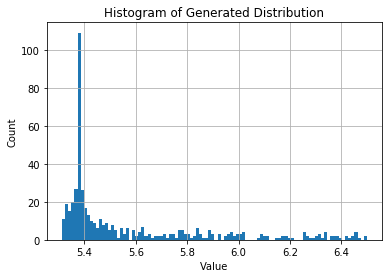

In [19]:
#Train the network
train()